In [1]:
# Imports

from OverwatchProcessData import get_vector_herostats
from OverwatchProcessData import get_competitive_rank, hero_stats
from OverwatchGatherData import Player, find_usernames

import numpy as np
import os

np.random.seed(3)

from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout

import keras.backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Loading Data

specific_stats = {}

for stat in hero_stats:
    
    hero, _, _ = stat.split(" ")
    
    if hero in specific_stats:
        
        specific_stats[hero].append(stat)
    
    else:
        
        specific_stats[hero] = [stat]

def generate_players(limit=1e10):
    
    for filename in os.listdir(os.path.join('..', 'profiles')):
        
        if limit < 0: return
        
        try: # If it can't read the player then just ignore file
            
            player = Player.from_file(os.path.join('..', 'profiles', filename))
        
            if 'error' not in player.json and get_competitive_rank(player, 'us'):

                yield player
                
                limit -= 1
                
            else: # Throw Away
                
                print('Deleting Profile...', filename)
                
                os.remove(os.path.join('..', 'profiles', filename))
                
        except:
            pass

def load_data():
    
    raw_data = {}

    for player in generate_players():

        rank = get_competitive_rank(player, 'us')

        if rank:
            
            comp_stats = player.json['us']['heroes']['stats']['competitive']
                
            for hero in comp_stats:
                
                try:
                    time_played = comp_stats[hero]['general_stats']['time_played']
                except:
                    time_played = -1

                if time_played >= .4: # Min Time Played
                        
                    if hero not in raw_data: raw_data[hero] = [], []

                    raw_data[hero][0].append(get_vector_herostats(player, 'us', stat_keys=specific_stats[hero]))
                    raw_data[hero][1].append(rank)
            
    for hero in raw_data:
        
        unscaled_X, unscaled_y = raw_data[hero]

        unscaled_X = np.array(unscaled_X, dtype=np.float64)
        unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
        print(hero.title(), unscaled_X.shape, unscaled_y.shape)
        
        raw_data[hero] = unscaled_X, unscaled_y
    
    return raw_data

len(specific_stats), len(specific_stats['mercy'])

(26, 116)

In [3]:
# Scale

def scale_data(hero_data):
    
    unscaled_X, unscaled_y = hero_data
    
    scaler_X = StandardScaler()

    X = scaler_X.fit_transform(unscaled_X)
    y = unscaled_y / 5000
    
    return X, y, scaler_X


In [4]:
# Metric

def acc_metric(y_true, y_pred):
    """
    Accuracy
    """
    diff = K.abs(y_pred - y_true) * 5000
    
    return K.mean(diff, axis=-1)


In [5]:
# Model

def get_model(hero):
    
    model = Sequential()
    
    model.add(Dense(160, input_dim=len(specific_stats[hero]), kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(160, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(160, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(160, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(160, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[acc_metric])
    
    return model


In [6]:
# Train wrapper

def train_model(model, *args, **kwargs):

    history = model.fit(*args, **kwargs, shuffle=True, validation_split=.10, verbose=0)
    
    return history

def get_hero_model(hero, hero_data=None, from_file=False):
    
    if from_file:
        
        model = load_model(os.path.join('..', 'models', '{}-sr.h5'.format(hero)))
        
        scaler_X = joblib.load(os.path.join('..', 'models', '{}-sr.pkl'.format(hero)))
        
        return None, model, scaler_X
    
    X, y, scaler_X = hero_data

    model = get_model(hero)
    
    ## Callbacks ##
    reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-8, verbose=0)
    e_stopping = EarlyStopping(patience=35)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', '{}-sr.h5'.format(hero)), 
                                 monitor='val_acc_metric', 
                                 verbose=0,
                                 save_best_only=True)
    ###############
    
    joblib.dump(scaler_X, os.path.join('..', 'models', '{}-sr.pkl'.format(hero)))

    history = train_model(model, X, y, epochs=2000, batch_size=64, callbacks=[reduce_LR, e_stopping, checkpoint])
    
    return history, model, scaler_X


In [7]:
# Predict

def predict_sr(model, player, scaler_for_X, hero):
    
    stats_vector = np.array([get_vector_herostats(player, 'us', stat_keys=specific_stats[hero])])
    
    X = scaler_for_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix) * 5000
    
    return int(sr)


In [8]:
# Run

if __name__ == "__main__":
    
    all_data = {}
    
    raw_data = load_data()
    
    for hero in raw_data:
        
        all_data[hero] = scale_data(raw_data[hero])


Winston (16217, 110) (16217,)
Mei (4430, 108) (4430,)
Moira (9058, 94) (9058,)
Orisa (10526, 93) (10526,)
Doomfist (1923, 87) (1923,)
Reaper (10868, 99) (10868,)
Sombra (2443, 91) (2443,)
Widowmaker (7084, 101) (7084,)
Reinhardt (18099, 98) (18099,)
Symmetra (4777, 97) (4777,)
Mccree (12680, 96) (12680,)
Lucio (15499, 114) (15499,)
Soldier76 (18078, 114) (18078,)
Zarya (15992, 114) (15992,)
Mercy (19950, 116) (19950,)
Pharah (13188, 94) (13188,)
Ana (15465, 115) (15465,)
Genji (9828, 96) (9828,)
Zenyatta (15419, 103) (15419,)
Tracer (10723, 102) (10723,)
Dva (17278, 109) (17278,)
Torbjorn (4553, 108) (4553,)
Junkrat (12484, 97) (12484,)
Bastion (5369, 107) (5369,)
Hanzo (6340, 103) (6340,)
Roadhog (15629, 111) (15629,)


Training Winston
350.039065314
Training Zarya
370.690767586
Training Symmetra
465.821596368
Training Orisa
370.310174053
Training Doomfist
922.873393117
Training Reaper
338.489132454
Training Sombra
664.912986526
Training Widowmaker
391.450255227
Training Reinhardt
384.562223704
Training Mccree
334.916195404
Training Lucio
383.494788819
Training Soldier76
342.498125662
Training Mei
494.26491548
Training Tracer
382.073473147
Training Mercy
368.23033467
Training Pharah
369.017180772
Training Ana
354.987171544
Training Genji
339.335703952
Training Zenyatta
368.007460489
Training Moira
370.33703471
Training Dva
348.163679042
Training Torbjorn
430.204953671
Training Bastion
391.973052574
Training Junkrat
377.473226819
Training Hanzo
430.232471743
Training Roadhog
396.624093889


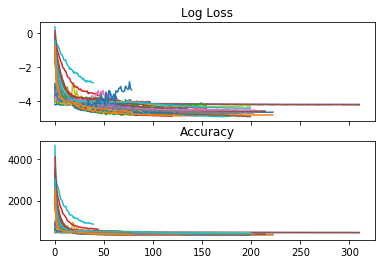

In [9]:
# Run 

if __name__ == "__main__":

    history_db = {}

    f, (loss_plot, acc_plot) = plt.subplots(2, 1, sharex=True)

    for hero in specific_stats:

        print('Training ' + hero.title())

        history, model, _ = get_hero_model(hero, hero_data=all_data[hero])

        loss, acc = np.log(history.history['val_loss']), history.history['val_acc_metric']
 
        loss_plot.plot(loss)
        acc_plot.plot(acc)
        
        loss, acc = np.log(history.history['loss']), history.history['acc_metric']

        loss_plot.plot(loss)
        acc_plot.plot(acc)

        history_db[hero] = [loss, acc]

        print(np.mean(acc[-10]))

    loss_plot.set_title('Log Loss')
    acc_plot.set_title('Accuracy')

    plt.show()


In [ ]:
# Load models from disk

if __name__ == "__main__":

    import keras.metrics
    keras.metrics.acc_metric = acc_metric # Weird Patch

    models = {}

    for hero in specific_stats:

        models[hero] = get_hero_model(hero, from_file=True)


In [ ]:
# Predict using all viable models

def predict_all(player):
    
    sr_predictions = []
    time_played = []

    for hero in specific_stats:
        
        player_hero_stats = player.json['us']['heroes']['stats']['competitive']

        if hero in player_hero_stats and player_hero_stats[hero]['general_stats']['time_played'] >= .4:

            _, model, scaler = models[hero]
                
            sr_predictions.append(predict_sr(model, player, scaler, hero))
            time_played.append(player_hero_stats[hero]['general_stats']['time_played'])
                
    return int(np.average(sr_predictions, weights=time_played))


In [ ]:
# Test

if __name__ == "__main__":

    with open('test_names.txt', 'r') as test:

        for battletag in find_usernames(test.read()):

            player = Player.from_web_battletag(battletag)

            actual = get_competitive_rank(player, 'us')
            p = predict_all(player)

            print("{} is {}, predicted {}".format(battletag, actual, p))
